# Album Investigations

In [4]:
album_name = "ready to die the remaster".lower()

album_frame = scrobbles[scrobbles["album"].str.lower() == album_name]# FILTER SCROBBLES
album_frame = album_frame.sort_index(ascending=False) # SORT
# album_frame = album_frame.loc[:, descriptor_headers] # DESCRIPTORS

total_time = album_frame["duration_ms"].sum() / (1000 * 60) # minutes
total_days = total_time / (60 * 24) # days

print(f'{album_frame.count()[0]:,d} scrobbles')
print(f'{total_days:.0f} days spent listening since Nov. 2017')
print(f'{total_time / days_since(first_day).days:.2f} minutes/day')

album_frame.describe()[1:]

231 scrobbles
1 days spent listening since Nov. 2017
0.79 minutes/day


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
mean,0.235890,0.731300,246063.596413,0.698152,0.001645,5.950673,0.223114,-6.969498,0.600897,0.353852,110.963507,3.955157,0.501817
std,0.161694,0.113785,52666.616121,0.094482,0.005694,3.331840,0.169553,1.551643,0.490816,0.115303,35.753685,0.207425,0.230002
min,0.024100,0.435000,91107.000000,0.501000,0.000000,0.000000,0.072600,-10.171000,0.000000,0.224000,78.610000,3.000000,0.095600
25%,0.088800,0.622000,220440.000000,0.630000,0.000000,4.000000,0.106000,-8.136000,0.000000,0.253000,89.820500,4.000000,0.305000
50%,0.191000,0.743000,252747.000000,0.694000,0.000003,6.000000,0.143000,-6.940000,1.000000,0.310000,93.725000,4.000000,0.543000
75%,0.422000,0.831000,285947.000000,0.791000,0.000036,8.000000,0.288000,-5.713000,1.000000,0.425000,118.624000,4.000000,0.680000
max,0.500000,0.913000,321293.000000,0.831000,0.023500,11.000000,0.779000,-4.639000,1.000000,0.702000,182.884000,4.000000,0.786000


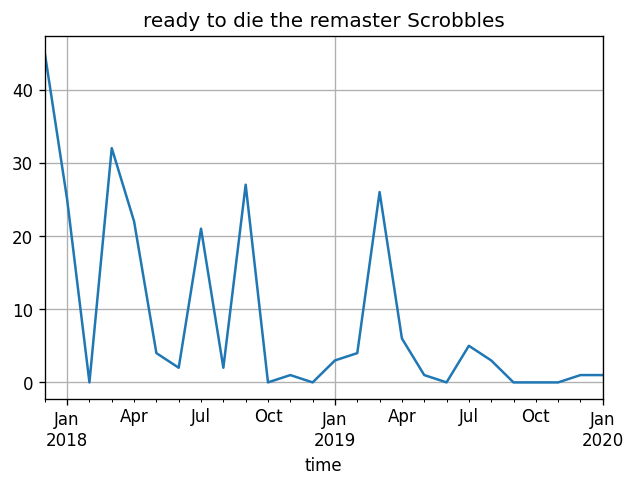

In [5]:
# resample by day and mean
album_frame.resample("1M").count()["track"].plot()

plt.title(f"{album_name} Scrobbles")
plt.grid()
plt.show()

## Average Descriptor

Below presents the average descriptor for the album. "*All Listened Tracks*" describes the descriptor based on the listening activity for this album. This takes into account how many times a track is listened to. "*Distinct Tracks*" takes only the distinct set of tracks that have been listened to and takes that average.

The difference between them could be described as which features are preferred for an album. If the blue bar is higher than the red, it would indicate that tracks from this album which have a higher value for this are listened to more. 

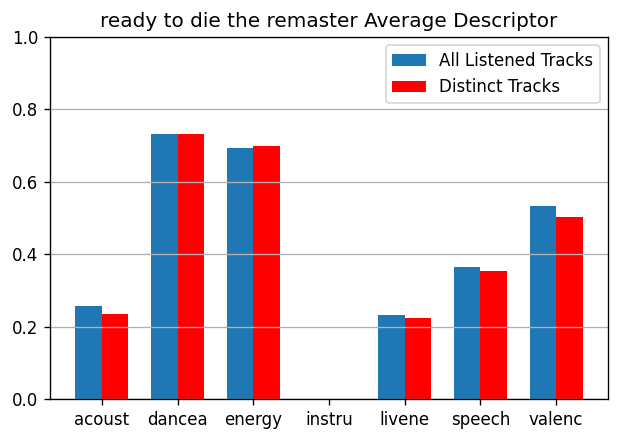

In [6]:
x = np.arange(len(float_headers))
width = 0.35

plt.bar(x - width/2, 
        album_frame.drop_duplicates(['uri'])[float_headers].mean(), 
        width, label='All Listened Tracks')
plt.bar(x + width/2, 
        album_frame[float_headers].mean(), 
        width, label='Distinct Tracks', color=(1, 0, 0))

plt.title(f"{album_name} Average Descriptor")
plt.legend(['All Listened Tracks', 'Distinct Tracks'])
plt.xticks(x, labels=[i[:6] for i in float_headers])
plt.ylim([0, 1])
plt.grid(axis='y')
plt.show()

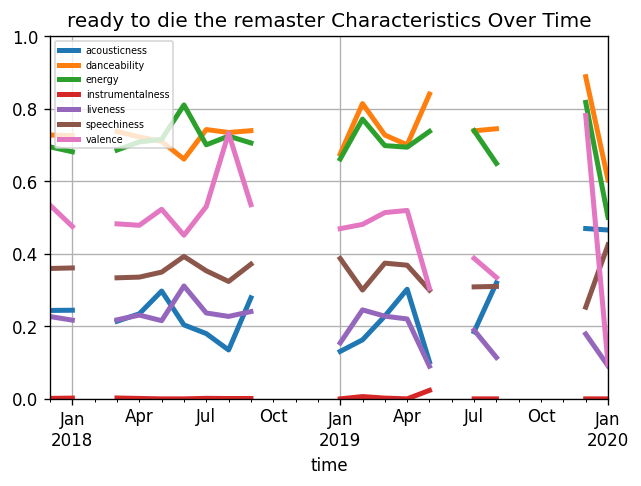

In [7]:
album_frame[float_headers].resample("1M").mean().plot(lw=3)

plt.title(f"{album_name} Characteristics Over Time")
plt.legend(loc = "upper left", fontsize = "xx-small")
plt.ylim([0, 1])
plt.grid()
plt.show()

# Album Listening Time

In [8]:
LIMIT = 25
fig_size = (7,(10/20)*LIMIT)
### STATS ###

stats_frame = scrobbles.reset_index()[["track", "album", "artist", "duration_ms"]]

track_count = stats_frame.groupby(['artist', 'album']).count()["track"]
track_count.name='count'

duration_sum = stats_frame.groupby(['artist', 'album']).sum()["duration_ms"]
duration_sum.name="duration_sum"

duration_average = stats_frame.groupby(['artist', 'album']).mean()["duration_ms"]
duration_average.name="duration_mean"

stats_frame = pd.concat([track_count, duration_sum, duration_average], axis=1).reset_index()

stats_frame = stats_frame[stats_frame["album"] != "Mirror Reaper"] # 1:30 hr long song, skews graphs
# stats_frame

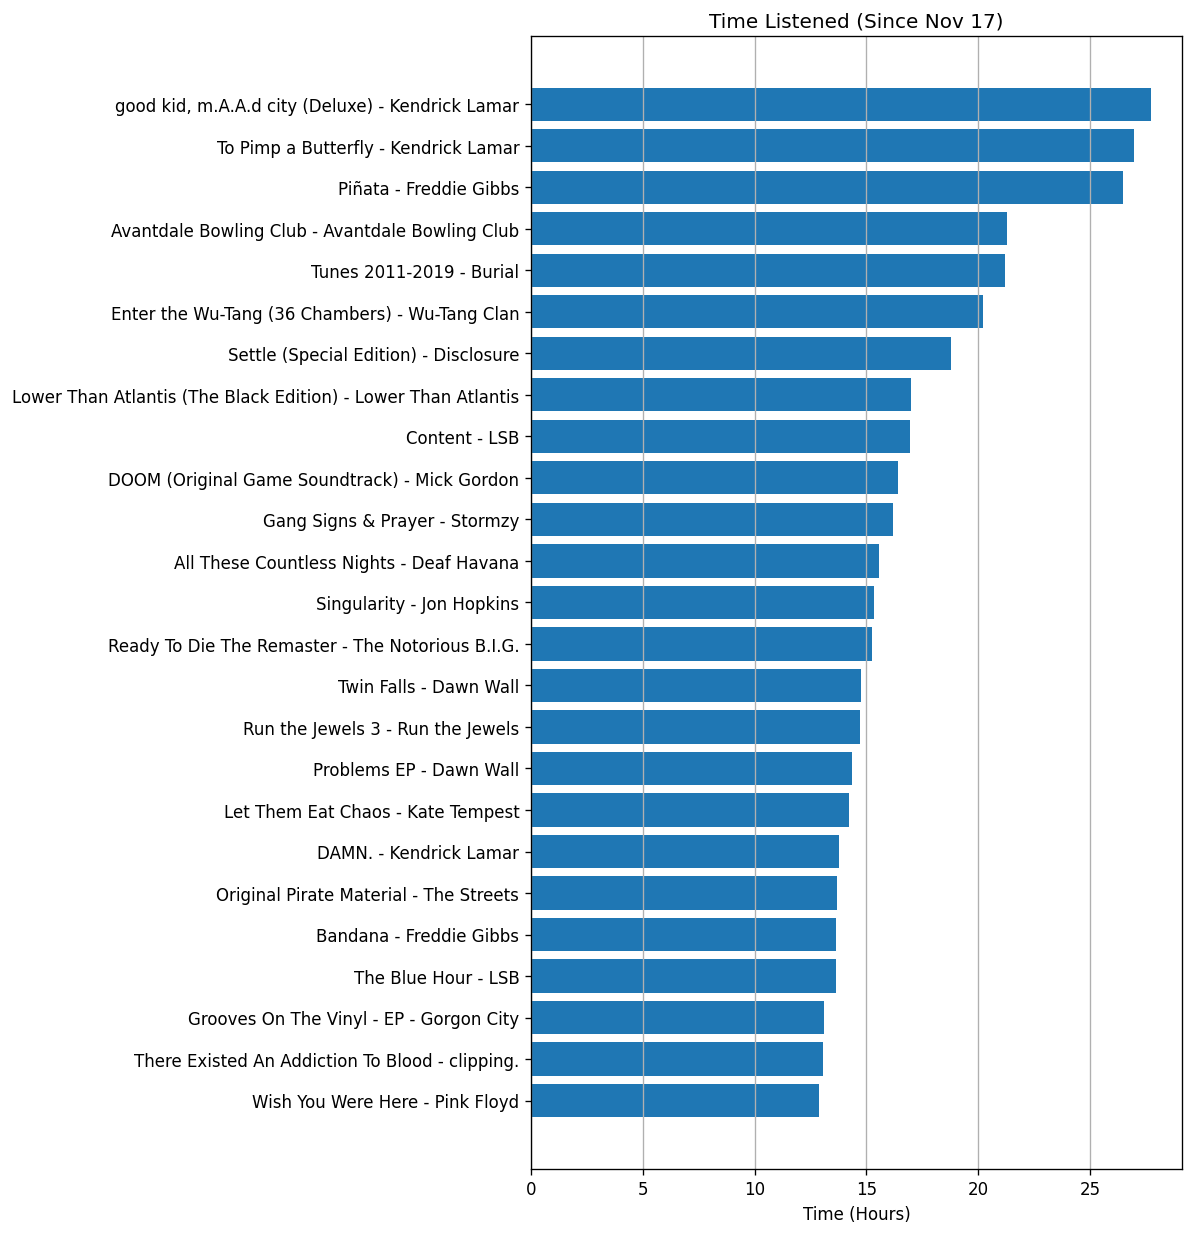

In [9]:
duration_frame = stats_frame.sort_values(by='duration_sum', ascending=False).head(LIMIT)

plt.figure(figsize=fig_size)
plt.barh(np.arange(len(duration_frame))[::-1], duration_frame["duration_sum"].to_numpy() / (1000 * 60 * 60) )
plt.yticks(np.arange(len(duration_frame))[::-1], labels=[f'{r["album"]} - {r["artist"]}' for i, r in duration_frame.iterrows()])
plt.xlabel("Time (Hours)")
plt.grid(axis="x")
plt.title("Time Listened (Since Nov 17)")
plt.show()

# Imports & Setup

In [2]:
from datetime import datetime

from google.cloud import bigquery
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

from analysis.net import get_spotnet, get_fmnet, get_playlist, track_frame
from analysis.query import *
from analysis import float_headers, days_since

import pandas as pd
import numpy as np

client = bigquery.Client()
spotnet = get_spotnet()
fmnet = get_fmnet()
cache = 'query.csv'
first_day = datetime(year=2017, month=11, day=3)

## Read Scrobble Frame

In [3]:
scrobbles = get_query(cache=cache)

## Write Scrobble Frame

In [4]:
scrobbles.reset_index().to_csv(cache, sep='\t')